## Correlation and Clustering Analysis of Chronic Disease Prevalence in the United States
### Clustering Heatmap and Dendrogram
Data Source: CDC, PLACES Dataset (2024 release)

The correlation analysis reveals three primary disease clusters that warrant careful attention:

#### Cardiovascular-Related Complex
The strongest correlations center around cardiovascular conditions, with CHD (Coronary Heart Disease) showing robust relationships with multiple conditions. The correlation between CHD and arthritis (0.813) is particularly notable, suggesting potential shared inflammatory pathways or common risk factors. This relationship likely reflects both biological mechanisms and shared demographic risk factors, particularly aging populations. (Relevant literature reference - "Rheumatoid Arthritis and Cardiovascular Disease" https://pmc.ncbi.nlm.nih.gov/articles/PMC3890244/)

The strong correlation between blood pressure and stroke (0.746) aligns with established clinical knowledge but importantly quantifies this relationship at the population level. This reinforces the critical importance of blood pressure management in stroke prevention strategies. (Relevant literature reference - "Why are strokes related to hypertension? Classic studies and hypotheses revisited" https://pubmed.ncbi.nlm.nih.gov/11564969/)

#### Metabolic Disease Network
Blood pressure demonstrates significant correlations with multiple conditions, including diabetes (0.722), suggesting a complex metabolic syndrome pattern at the population level. This clustering of conditions points to the importance of addressing fundamental lifestyle and environmental factors that contribute to metabolic health.

#### Respiratory-Cardiovascular Interface
The correlation between COPD and cardiovascular conditions (CHD: 0.776, stroke: 0.764) highlights an important clinical intersection that may be underappreciated in current care models. This relationship suggests the need for integrated treatment approaches for patients with respiratory conditions. (Relevant literature reference - "Defining the relationship between COPD and CVD: what are the implications for clinical practice?" https://pmc.ncbi.nlm.nih.gov/articles/PMC5937157/)

In [2]:
import sys
from pathlib import Path

# Setup paths
PROJECT_ROOT = Path().resolve().parents[0]
sys.path.append(str(PROJECT_ROOT))

In [3]:
from config import *

In [4]:
import pandas as pd

# Load data
file_path = get_file_path(2024)
df = pd.read_csv(file_path)
# df.head()

# Get health outcomes and measures plus location and population
health_outcomes = get_measures_by_category('health_outcomes')
outcome_cols = [get_prevalence_column(m) for m in health_outcomes]
ci_cols = [get_ci_column(m) for m in health_outcomes]
loc_pop_cols = ['StateAbbr', 'StateDesc', 'CountyName', 'CountyFIPS', 'TractFIPS', 'TotalPopulation', 'TotalPop18plus', 'Geolocation']
healthoutcomes_df = df[loc_pop_cols + outcome_cols]
# healthoutcomes_df.head()

In [5]:
import numpy as np

# For calculating means of prevalence columns weighted by populations
def weighted_mean(series, weights):
    return np.average(series, weights=weights)

# Specify aggregation functions for each column
first_cols = ['StateAbbr', 'StateDesc', 'CountyName']
sum_cols = ['TotalPopulation', 'TotalPop18plus']
aggregation_functions = {col: 'first' for col in first_cols}
aggregation_functions.update({col: 'sum' for col in sum_cols})
# aggregation_functions.update({col: lambda x: list(x) for col in ['Geolocation']}) # can calculate centroid if needed
aggregation_functions.update({col: lambda x: weighted_mean(x, df.loc[x.index, 'TotalPopulation']) for col in outcome_cols})
# aggregation_functions.update({col: lambda x: agg_conf_interval(x) for col in ci_cols}) # we can determine this function later if needed

county_healthoutcomes_df = df.groupby('CountyFIPS').agg(aggregation_functions).reset_index()


Highly Correlated Disease Pairs:
               disease1            disease2  correlation
0   ARTHRITIS_CrudePrev    BPHIGH_CrudePrev     0.766054
1   ARTHRITIS_CrudePrev       CHD_CrudePrev     0.813134
2   ARTHRITIS_CrudePrev      COPD_CrudePrev     0.724939
3      BPHIGH_CrudePrev       CHD_CrudePrev     0.752955
4      BPHIGH_CrudePrev      COPD_CrudePrev     0.724661
5      BPHIGH_CrudePrev  DIABETES_CrudePrev     0.721599
6      BPHIGH_CrudePrev    STROKE_CrudePrev     0.745839
7         CHD_CrudePrev      COPD_CrudePrev     0.776283
8         CHD_CrudePrev    STROKE_CrudePrev     0.739906
9        COPD_CrudePrev    STROKE_CrudePrev     0.763524
10   DIABETES_CrudePrev    STROKE_CrudePrev     0.768220


<Figure size 1500x1200 with 0 Axes>

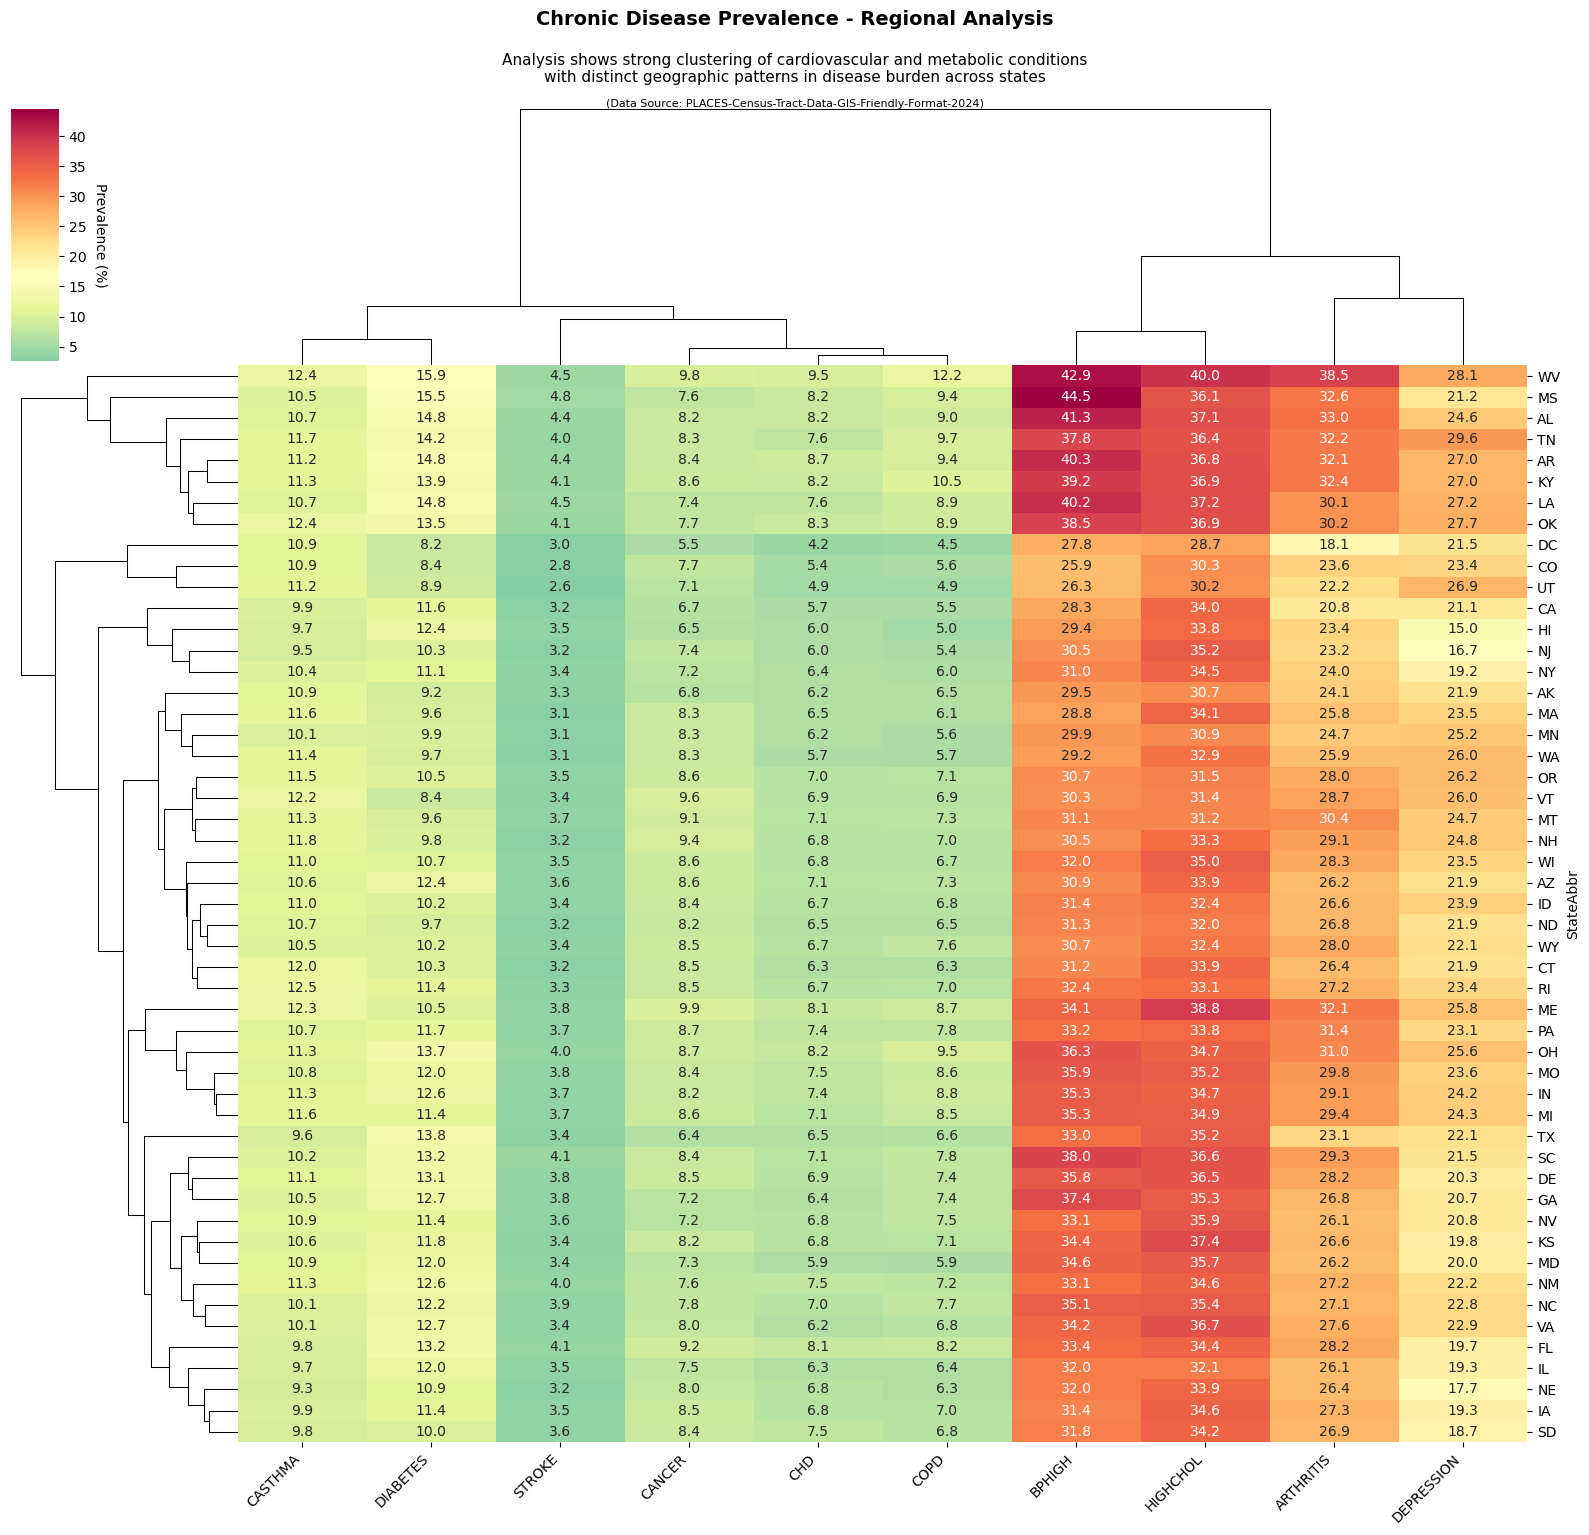

In [8]:
"""
Chronic Disease Pattern Analysis and Visualization

This module provides tools for analyzing and visualizing chronic disease patterns
across U.S. states using CDC PLACES data. It implements population-weighted clustering
analysis and creates publication-quality visualizations of disease burden distributions.

Primary functions:
- create_disease_burden_heatmap: Generates clustered heatmap visualization
- analyze_disease_clusters: Performs correlation analysis between health outcomes
"""

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist, squareform

def create_disease_burden_heatmap(df, outcome_cols, output_path=None):
    """
    Creates a hierarchically clustered heatmap of disease prevalence across states.
    
    The visualization employs population-weighted averaging and hierarchical clustering
    to reveal geographic patterns in disease burden. It uses an inverted spectral
    color scheme where higher prevalence is shown in red and lower in blue.
    
    Args:
        df: DataFrame containing health data with state and population information
        outcome_cols: List of column names for health outcomes to analyze
        output_path: Optional path to save the visualization
        
    Returns:
        matplotlib.figure.Figure object containing the visualization
    """
    def weighted_average(x):
        values = df.loc[x.index, 'TotalPopulation']
        mask = ~x.isna()
        return np.average(x[mask], weights=values[mask]) if mask.sum() > 0 else np.nan
    
    # Prepare state-level aggregated data
    state_aggregation = {'TotalPopulation': 'sum'}
    state_aggregation.update({col: weighted_average for col in outcome_cols})
    state_data = df.groupby('StateAbbr').agg(state_aggregation)
    
    # Process data for visualization
    data_matrix = state_data[outcome_cols]
    data_matrix = data_matrix.fillna(data_matrix.mean())
    data_matrix.columns = [col.replace('_CrudePrev', '') for col in outcome_cols]
    
    # Configure visualization parameters
    spectral_cmap = sns.color_palette("Spectral_r", as_cmap=True)
    plt.figure(figsize=(15, 12))
    
    try:
        # Generate clustered heatmap
        g = sns.clustermap(
            data_matrix,
            cmap=spectral_cmap,
            center=data_matrix.mean().mean(),
            vmin=data_matrix.min().min(),
            vmax=data_matrix.max().max(),
            annot=True,
            fmt='.1f',
            cbar_pos=(0.01, 0.8, 0.03, 0.18),
            figsize=(16, 14),
            dendrogram_ratio=(.15, .2),
            row_cluster=True,
            col_cluster=True,
            colors_ratio=0.03,
            tree_kws={'linewidths': 0.75, 'colors': 'black'}
        )
        
        # Add titles and context
        g.fig.text(0.5, 1.04, 'Chronic Disease Prevalence - Regional Analysis',
                  fontsize=14, fontweight='bold', ha='center')
        g.fig.text(0.5, 1.02,
                  'Analysis shows strong clustering of cardiovascular and metabolic conditions\n'
                  'with distinct geographic patterns in disease burden across states',
                  fontsize=11, ha='center', va='top')
        g.fig.text(0.5, 0.98, 
                  '(Data Source: PLACES-Census-Tract-Data-GIS-Friendly-Format-2024)',
                  fontsize=8, ha='center', va='bottom')
        
        # Format labels and legends
        g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(),
                                    rotation=45, ha='right', fontsize=10)
        g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(),
                                    rotation=0, fontsize=10)
        g.ax_cbar.set_ylabel('Prevalence (%)', rotation=270, labelpad=15)
        
    except Exception as e:
        print(f"Warning: Clustering failed, creating simple heatmap instead. Error: {e}")
        sns.heatmap(data_matrix, cmap=spectral_cmap,
                   center=data_matrix.mean().mean(),
                   annot=True, fmt='.1f')
        plt.title('Disease Burden Patterns Across States')
        plt.xticks(rotation=45, ha='right')
    
    if output_path:
        plt.savefig(output_path, bbox_inches='tight', dpi=300, facecolor='white')
    
    return plt.gcf()

def analyze_disease_clusters(df, outcome_cols):
    """
    Performs population-weighted correlation analysis between health outcomes.
    
    Args:
        df: DataFrame containing health data
        outcome_cols: List of health outcome column names
    
    Returns:
        Dictionary containing correlation matrix and highly correlated disease pairs
    """
    def weighted_corr(x, y, weights):
        mask = ~(x.isna() | y.isna())
        if mask.sum() < 2:
            return np.nan
        return np.cov(x[mask], y[mask], aweights=weights[mask])[0,1] / \
               (np.std(x[mask]) * np.std(y[mask]))
    
    # Calculate correlation matrix
    corr_matrix = pd.DataFrame(index=outcome_cols, columns=outcome_cols)
    weights = df['TotalPopulation']
    
    for i, col1 in enumerate(outcome_cols):
        for j, col2 in enumerate(outcome_cols):
            if i <= j:
                correlation = weighted_corr(df[col1], df[col2], weights)
                corr_matrix.iloc[i,j] = correlation
                if i != j:
                    corr_matrix.iloc[j,i] = correlation
    
    # Identify strongly correlated disease pairs
    high_correlations = [
        {'disease1': outcome_cols[i],
         'disease2': outcome_cols[j],
         'correlation': corr_matrix.iloc[i,j]}
        for i in range(len(outcome_cols))
        for j in range(i+1, len(outcome_cols))
        if abs(corr_matrix.iloc[i,j]) > 0.7
    ]
    
    return {
        'correlation_matrix': corr_matrix,
        'high_correlations': pd.DataFrame(high_correlations)
    }

def main():
    """
    Main execution function that loads data and generates analysis outputs.
    """
    file_path = get_file_path(2024)
    df = pd.read_csv(file_path)
    
    outcome_cols = [
        'ARTHRITIS_CrudePrev', 'BPHIGH_CrudePrev', 'CANCER_CrudePrev',
        'CASTHMA_CrudePrev', 'CHD_CrudePrev', 'COPD_CrudePrev',
        'DEPRESSION_CrudePrev', 'DIABETES_CrudePrev', 'HIGHCHOL_CrudePrev',
        'STROKE_CrudePrev'
    ]
    
    result_map_path = PROJECT_ROOT / 'results' / 'regional_analysis' / 'disease_burden_heatmap.png'
    heatmap = create_disease_burden_heatmap(df, outcome_cols,
                                          output_path=result_map_path)
    analysis_results = analyze_disease_clusters(df, outcome_cols)
    
    print("\nHighly Correlated Disease Pairs:")
    print(analysis_results['high_correlations'])
    
    return heatmap, analysis_results

if __name__ == "__main__":
    heatmap, analysis = main()

## Disease Correlation Patterns

The dendrogram structure shows two primary clusters of health conditions:

##### High-Prevalence Cluster
Blood pressure (BPHIGH), high cholesterol (HIGHCHOL), and arthritis form a tightly correlated cluster, with prevalence rates consistently ranging from 35-43%. This suggests common underlying risk factors, potentially related to aging demographics and metabolic health. States showing high prevalence in this cluster often face significant chronic disease management challenges.

##### Moderate-Prevalence Cluster
COPD, CHD (coronary heart disease), and cancer show moderate correlation and lower overall prevalence (6-12%). The geographic distribution suggests environmental and socioeconomic factors may play important roles in these conditions.

## State-Level Patterns

##### High Disease Burden States
States clustering at the top of the heatmap show consistently elevated rates across multiple conditions. These states typically show:
- BPHIGH prevalence exceeding 40%
- Arthritis rates above 32%
- Higher than average rates of COPD and diabetes
This pattern is particularly prominent in southeastern states, aligning with known health disparities in this region.

##### Lower Disease Burden States
States clustering at the bottom of the heatmap demonstrate:
- BPHIGH prevalence below 35%
- Lower rates of arthritis (25-28%)
- Relatively lower prevalence of COPD and diabetes
These states often correspond to regions with higher socioeconomic indicators and better healthcare access.

## Public Health Implications

These correlation patterns have several important implications for public health strategy:

1. The high degree of correlation between multiple conditions supports the case for integrated chronic disease management programs rather than condition-specific interventions.

2. The strong clustering of cardiovascular risk factors suggests that population-level interventions targeting fundamental lifestyle factors could have multiplicative benefits across several conditions.

3. The consistent correlation patterns involving stroke (correlating significantly with diabetes: 0.768, COPD: 0.764, and blood pressure: 0.746) suggest that stroke prevention strategies should take a comprehensive approach addressing multiple risk factors.

## Healthcare Delivery Considerations

These findings suggest the need to evolve our healthcare delivery models in several ways:

First, the strong correlations between conditions indicate that care models should be designed to address multiple chronic conditions simultaneously rather than treating each in isolation.

Second, the clustering of conditions suggests that risk assessment tools should consider the multiplicative effects of having multiple correlated conditions.

## Limitations and Considerations

The analysis is based on crude prevalence rates and may not fully account for age-adjusted populations or socioeconomic factors. Additionally, access to healthcare and diagnosis patterns may influence reported prevalence rates.

This comprehensive analysis provides valuable insights for public health planning and resource allocation, while highlighting the need for both broad-based and regionally-targeted intervention strategies.

## Future Research Directions

These correlation patterns point to several important areas for future research:

1. Investigation of shared biological mechanisms, particularly in the arthritis-cardiovascular relationship, which shows unexpectedly strong correlations.

2. Examination of how these disease correlations vary across different demographic and socioeconomic groups.

3. Evaluation of integrated intervention strategies that target multiple correlated conditions simultaneously.

This correlation analysis provides valuable insights for both clinical practice and public health policy, suggesting the need for more integrated approaches to chronic disease prevention and management.